In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm
import seaborn as sns
import xgboost

from sklearn import neural_network
from scipy.stats import hmean
import pickle

In [2]:
df = pd.read_csv("wns-wizard-av/Train/train.csv")
df.head(10)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0
5,3416a75f4cea9109507cacd8e2f2aefc,2018-11-15 00:03:00,67352,409,latest,1,0
6,f457c545a9ded88f18ecee47145a72c0,2018-11-15 00:03:00,64356,190,intermediate,0,0
7,72b32a1f754ba1c09b3695e0cb6cde7f,2018-11-15 00:04:00,27329,481,latest,0,0
8,fc490ca45c00b1249bbe3554a4fdf6fb,2018-11-15 00:05:00,83318,386,old,0,0
9,d2ddea18f00665ce8623e36bd4e3c7c5,2018-11-15 00:05:00,70206,190,latest,0,0


In [3]:
print(df.info(), "\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: int64(4), object(3)
memory usage: 12.7+ MB
None 




In [4]:
# Changing impression time and server time from object to datetime
df["impression_time"] = pd.to_datetime(df["impression_time"], format="%Y-%m-%d %H:%M:%S")

In [5]:
# Describe advertisement dataset
print(df.describe())

             user_id       app_code          is_4G       is_click
count  237609.000000  237609.000000  237609.000000  237609.000000
mean    46454.526828     249.099971       0.361312       0.045714
std     26802.726666     135.213609       0.480382       0.208864
min         0.000000       0.000000       0.000000       0.000000
25%     23197.000000     163.000000       0.000000       0.000000
50%     46597.000000     213.000000       0.000000       0.000000
75%     69684.000000     385.000000       1.000000       0.000000
max     92586.000000     522.000000       1.000000       1.000000


In [6]:
print(df["os_version"].describe(), "\n")
print(df["is_click"].describe())

count     237609
unique         3
top       latest
freq      129216
Name: os_version, dtype: object 

count    237609.000000
mean          0.045714
std           0.208864
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_click, dtype: float64


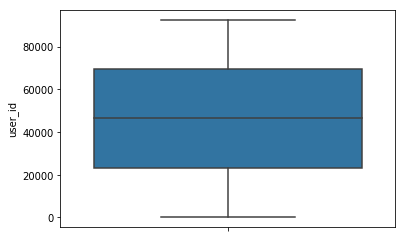

In [7]:
a = sns.boxplot(y=df["user_id"])

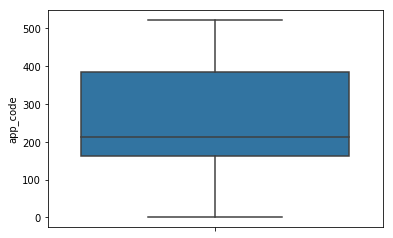

In [8]:
b = sns.boxplot(y=df["app_code"])

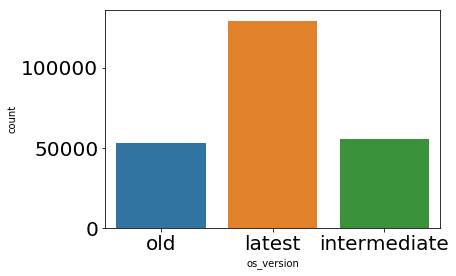

In [9]:
a = sns.countplot(x = df["os_version"])
a.tick_params(labelsize=20)

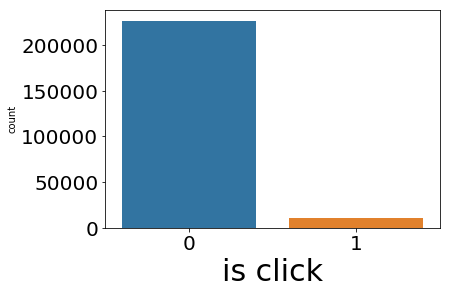

In [10]:
b = sns.countplot(df["is_click"])
b.set_xlabel("is click",fontsize=30)
b.tick_params(labelsize=20)

#### Dataset about advertisement quality
* There is 10,862 user that click from 237,609 or only about 0.04571 imbalance at this attribute
* There is no outlier in appcode and useri ID using IQR
* There is no missing value

## Overall Data Quality
* There are imbalance
    * Clicked ad and not clicked ad

## Data Preparation

### Objective: Predict whether user with some characteristic will clicked the ad or not

#### Drop every column not related

In [11]:
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [12]:
# Impression id is not determined whether user will click the ad or not
# Impression time only range from november to december, this is not readlly determine a user will click or not at other month
df = df.drop(["impression_id", "impression_time"], axis=1)

In [13]:
df.head()

,user_id,app_code,os_version,is_4G,is_click
0,87862,422,old,0,0
1,63410,467,latest,1,1
2,71748,259,intermediate,1,0
3,69209,244,latest,1,0
4,62873,473,latest,0,0


#### Make test csv

In [14]:
df["os_version"] = df["os_version"].astype('category')
df.dtypes

user_id          int64
app_code         int64
os_version    category
is_4G            int64
is_click         int64
dtype: object

In [15]:
# Change app_code into categorical int
df["os_version_int"] = df["os_version"].cat.codes
df

,user_id,app_code,os_version,is_4G,is_click,os_version_int
0,87862,422,old,0,0,2
1,63410,467,latest,1,1,1
2,71748,259,intermediate,1,0,0
3,69209,244,latest,1,0,1
4,62873,473,latest,0,0,1
5,67352,409,latest,1,0,1
6,64356,190,intermediate,0,0,0
7,27329,481,latest,0,0,1
8,83318,386,old,0,0,2
9,70206,190,latest,0,0,1


In [16]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

In [17]:
print(len(df_train), len(df_test))

190043 47566


In [18]:
predictors = ["app_code", "os_version_int", "is_4G"]

In [19]:
lgb = lightgbm.LGBMClassifier(n_estimators=650, max_depth=5, learning_rate=0.005, colsample_bytree=0.6, random_state=2019)

In [20]:
lgb.fit(df_train[predictors], df_train["is_click"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', learning_rate=0.005, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=650, n_jobs=-1, num_leaves=31, objective=None,
        random_state=2019, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
lgb_preds = lgb.predict_proba(df_test[predictors])[:,1]
lgb_preds_tr = lgb.predict_proba(df_train[predictors])[:,1]

In [22]:
metrics.roc_auc_score(df_train["is_click"], lgb_preds_tr), metrics.roc_auc_score(df_test["is_click"], lgb_preds)

(0.6890383666864839, 0.6912688027340077)

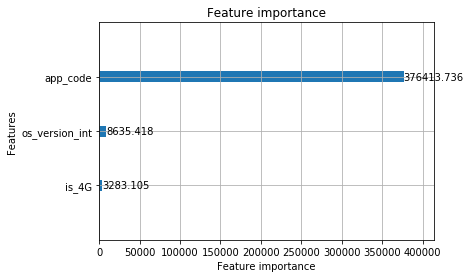

In [23]:
lightgbm.plot_importance(lgb, importance_type="gain")

In [24]:
nn = neural_network.MLPClassifier(hidden_layer_sizes=(30, 15), verbose=1, random_state=1000)

In [25]:
nn.fit(df_train[predictors], df_train["is_click"])

Iteration 1, loss = 0.40868101
Iteration 2, loss = 0.19257510
Iteration 3, loss = 0.19204421
Iteration 4, loss = 0.19225607
Iteration 5, loss = 0.19110006
Iteration 6, loss = 0.19164183
Iteration 7, loss = 0.19232459
Iteration 8, loss = 0.19087874
Iteration 9, loss = 0.18996490
Iteration 10, loss = 0.19058617
Iteration 11, loss = 0.18914187
Iteration 12, loss = 0.19018174
Iteration 13, loss = 0.18939952
Iteration 14, loss = 0.18878928
Iteration 15, loss = 0.18842726
Iteration 16, loss = 0.18843039
Iteration 17, loss = 0.18853012
Iteration 18, loss = 0.18850325
Iteration 19, loss = 0.18798989
Iteration 20, loss = 0.18795858
Iteration 21, loss = 0.18787950
Iteration 22, loss = 0.18742091
Iteration 23, loss = 0.18718593
Iteration 24, loss = 0.18733899
Iteration 25, loss = 0.18726574
Iteration 26, loss = 0.18682284
Iteration 27, loss = 0.18698699
Iteration 28, loss = 0.18685227
Iteration 29, loss = 0.18679213
Iteration 30, loss = 0.18653447
Iteration 31, loss = 0.18644404
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 15), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1000, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [ ]:
nn_preds = nn.predict_proba(df_test[predictors])[:,1]
nn_preds_tr = nn.predict_proba(df_train[predictors])[:,1]

In [ ]:
metrics.roc_auc_score(df_train["is_click"], nn_preds_tr), metrics.roc_auc_score(df_test["is_click"], nn_preds)

In [ ]:
pickle.dump(lgb, open('lgb_model.pkl', 'wb'))

In [ ]:
pickle.dump(nn, open('nn_model.pkl','wb'))